# Customer Lifecycle Prediction & Optimization
A practical, business-standard, step-by-step guide to predict Customer Lifetime Value (CLV) for a subscription model (Adobe-like SaaS) and generate recommendations to improve CLV.

1. Train a churn prediction model
2. Forecast CLV for 12 months
3. Simulate two improvement strategies:
   1. Discount Strategy
   2. Cross-Sell Strategy

**CLV using churn-adjusted revenue**

$$
\text{CLV} = \sum_{t=1}^{T} 
\frac{\text{Revenue}_t \cdot (1 - \text{ChurnProbability}_t)}{(1+r)^t}
$$

where 
* r = monthly discount rate

This captures two facts:

1. **Future revenue is uncertain**  
   → use survival probability:  $1 - \text{churn probability}$

2. **Future revenue is worth less**  
   → use the discount factor: $\frac{1}{(1 + r)^t}$


In [27]:
# ============================================================
# 1. Imports
# ============================================================

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

# ============================================================
# 2. CREATE SYNTHETIC DATASET
# ============================================================

n = 3000

data = pd.DataFrame({
    "user_id": np.arange(n),
    "product": np.random.choice(["Photoshop", "Illustrator", "Acrobat"], n),
    "subscription_price": np.random.choice([9.99, 19.99, 29.99], n),
    "daily_usage": np.random.gamma(3, 1.2, n),
    "monthly_usage": np.random.gamma(20, 2.0, n),
    "tenure_months": np.random.randint(1, 24, n),
    "discount_received": np.random.choice([0,1], n, p=[0.8,0.2]),
    "cross_sell_adopted": np.random.choice([0,1], n, p=[0.9,0.1]),
    "churned_last_month": np.random.choice([0,1], n, p=[0.9,0.1])
})

# Map churn rate by product
segment_churn_rate = {
    "Photoshop": 0.08,
    "Illustrator": 0.12,
    "Acrobat": 0.06
}
data["segment_churn_rate"] = data["product"].map(segment_churn_rate)


In [28]:
data.head()

,user_id,product,subscription_price,daily_usage,monthly_usage,tenure_months,discount_received,cross_sell_adopted,churned_last_month,segment_churn_rate
0,0,Acrobat,19.99,3.049120,47.659785,11,0,0,0,0.06
1,1,Photoshop,19.99,3.028513,43.683372,13,0,0,0,0.08
2,2,Acrobat,29.99,5.814616,38.477138,20,0,0,0,0.06
3,3,Acrobat,29.99,2.194361,23.365149,10,0,0,0,0.06
4,4,Photoshop,29.99,1.275284,51.477170,13,0,0,0,0.08


In [29]:
# ============================================================
# 3. ONE-HOT ENCODE PRODUCT COLUMN
# ============================================================

data = pd.get_dummies(data, columns=["product"], drop_first=True)

# ============================================================
# 4. DEFINE FEATURES AND TRAIN TEST SPLIT
# ============================================================

features = [
    "subscription_price",
    "daily_usage",
    "monthly_usage",
    "tenure_months",
    "discount_received",
    "cross_sell_adopted",
    "segment_churn_rate",
    "product_Illustrator",
    "product_Photoshop"
]

X = data[features]
y = data["churned_last_month"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================================
# 5. TRAIN CHURN MODEL
# ============================================================

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# ============================================================
# 6. CHURN FORECAST FUNCTION (12 months)
# ============================================================

def forecast_12_month_churn(user_row):
    """Forecast churn probability for each of the next 12 months."""
    
    churn_probs = []
    
    # Only keep model features
    features_current = user_row[features].copy()

    for t in range(12):
        # Predict using a DataFrame to preserve feature names
        input_df = pd.DataFrame([features_current], columns=features)
        p = model.predict_proba(input_df)[0, 1]
        churn_probs.append(p)

        # Simulate progression over time
        # Simplified example, only two features change over time:
        features_current["tenure_months"] += 1
        features_current["monthly_usage"] *= np.random.uniform(0.98, 1.05)

    return np.array(churn_probs)

# ============================================================
# 7. CALCULATE CLV
# ============================================================

def calculate_clv(user_row, churn_forecast, discount_rate=0.01):
    """Compute CLV (present value adjusted) over 12 months."""
    monthly_price = user_row["subscription_price"]
    clv = 0
    
    for t in range(12):
        survival_prob = 1 - churn_forecast[t]
        monthly_rev = monthly_price * survival_prob
        clv += monthly_rev / ((1 + discount_rate) ** t)
    
    return clv

=== CLV RESULTS ===
Baseline CLV:     $ 322.54
10% Discount CLV: $ 290.95
Cross-Sell CLV:   $ 316.32


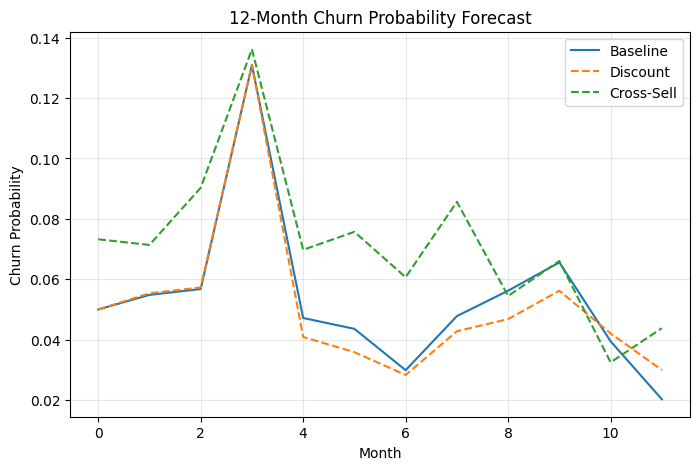

In [31]:
# ============================================================
# 8. RUN EXAMPLE USER FORECAST + STRATEGY SIMULATIONS
# ============================================================

example_user = data.sample(1, random_state=42).iloc[0]

# Baseline
churn_baseline = forecast_12_month_churn(example_user)
clv_baseline = calculate_clv(example_user, churn_baseline)

# Strategy A: 10% discount
user_discount = example_user.copy()
user_discount["subscription_price"] *= 0.9

churn_discount = forecast_12_month_churn(user_discount)
clv_discount = calculate_clv(user_discount, churn_discount)

# Strategy B: Cross-sell (increase usage)
user_crosssell = example_user.copy()
user_crosssell["monthly_usage"] *= 1.2
user_crosssell["daily_usage"] *= 1.2

churn_crosssell = forecast_12_month_churn(user_crosssell)
clv_crosssell = calculate_clv(user_crosssell, churn_crosssell)

print("=== CLV RESULTS ===")
print("Baseline CLV:     $", round(clv_baseline, 2))
print("10% Discount CLV: $", round(clv_discount, 2))
print("Cross-Sell CLV:   $", round(clv_crosssell, 2))

# ============================================================
# 9. VISUALIZE CHURN FORECAST
# ============================================================

plt.figure(figsize=(8,5))
plt.plot(churn_baseline, label="Baseline")
plt.plot(churn_discount, linestyle='--', label="Discount")
plt.plot(churn_crosssell, linestyle='--', label="Cross-Sell")
plt.xlabel("Month")
plt.ylabel("Churn Probability")
plt.legend()
plt.title("12-Month Churn Probability Forecast")
plt.grid(alpha=0.3)
plt.show()